# Supervised Variational Auto Encoder - Version 1

In [4]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam,Adagrad

from MiraBest import MiraBest

In [5]:

import torch.nn.functional as F


In [6]:
from PIL import Image # Module for image rotation (making use of PIL)

In [7]:
from FRDEEP import FRDEEPF

In [8]:
import matplotlib.pyplot as plt

In [9]:
pyro.__version__

'0.4.1'

In [10]:
torch.cuda.is_available()

True

## Download FRDEEP Data

In [11]:
def dataloader_first():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

    trainset = MiraBest(root='./FIRST_data', train=True, download=True, transform=transform)  
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))
    
    classes = ('FRI', 'FRII') #First class if FR1 and second class is FR2
    
    array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array
    array_label= next(iter(trainloader))[1].numpy()
    
    augmented_data=np.zeros((len(array_train)*36,1,100,100))
    
    augmented_data_label = np.zeros((len(array_train)*36,1))
    
    count=0
    
    for j in range(0,len(array_train)):
        image_object=Image.fromarray(array_train[j,0,:,:])
        for i in range(0,36):
            rotated=image_object.rotate(i*10)
            imgarr = np.array(rotated)
            temp_img_array=imgarr[25:125,25:125]
            augmented_data[count,0,:,:]=temp_img_array
            augmented_data_label[count,:]=array_label[j]
            count+=1
    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))
    
    X=augmented_data
    Y=augmented_data_label
    
    X_random_mix=np.take(X,np.random.RandomState(seed=42).permutation(X.shape[0]),axis=0,out=X)
    Y_random_mix=np.take(Y,np.random.RandomState(seed=42).permutation(Y.shape[0]),axis=0,out=Y)
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X_random_mix])
    tensor_y = torch.stack([torch.Tensor(i) for i in Y_random_mix])
    
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=100, shuffle=True) # create your dataloader
    
    #--------------------------------------Add Section for Test data------------------------------------
    
    # Cropping of the Testing Images to 100 by 100 pixels
    
    
    testset = MiraBest(root='./FIRST_data', train=False, download=True, transform=transform) 
    
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size=len(testset))

    array_test= next(iter(testloader))[0].numpy()
    
    test_labels = next(iter(testloader))[1].numpy()
    
    test_data_reduced=np.zeros((len(array_test),1,100,100))
    test_data_label = np.zeros((len(array_test),1))
    for k in range (0,len(array_test)):
        test_data_reduced[k][0][:][:] = array_test[k][0][25:125,25:125]
        test_data_label[k,:]=test_labels[k]
    
    test_data_reduced=(test_data_reduced-np.min(test_data_reduced))/(np.max(test_data_reduced)-np.min(test_data_reduced))
    
    
    
    tensor_test = torch.stack([torch.Tensor(i) for i in test_data_reduced])
    tensor_test_label = torch.stack([torch.Tensor(i) for i in test_data_label])
    
    first_augmented_dataset_test = torch.utils.data.TensorDataset(tensor_test,tensor_test_label) # create your datset
    
    first_dataloader_test = torch.utils.data.DataLoader(first_augmented_dataset_test,batch_size=50, shuffle=True) # create your dataloader
    
    
    
    
    return first_dataloader,first_dataloader_test

In [12]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [9]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

## Rework on EncoderZ and Decoder so that these adapts to FIRST Radio Images

In [189]:
class EncoderZ(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, y_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim):
        super(EncoderZ, self).__init__()
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim1) # x_dim=10000 + y_dim=2 to h_dim1=4096 
        self.fc2 = nn.Linear(h_dim1, h_dim2) #h_dim1=4096 to h_dim2=2048
        self.fc3 = nn.Linear(h_dim2, h_dim3) #h_dim2=2048 to h_dim3=1024
        self.fc4 = nn.Linear(h_dim3, h_dim4) #h_dim3=1024 to h_dim4=512
        self.fc5 = nn.Linear(h_dim4, h_dim5) #h_dim4=512 to h_dim5=256
        self.fc61 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        self.fc62 = nn.Linear(h_dim5, z_dim) #h_dim5=256 to z_dim=2
        self.softplus = nn.Softplus()

    def forward(self, x_y_2):
        [x,y]=x_y_2
        
        x = x.reshape(-1, 10000) 
        y = y.reshape(-1, 2) 
        
        x_y_1 = torch.cat((x,y), dim=1) #I think that this should concatenate the two inputs if this does work then test it independenlty
        x_y_1 = x_y_1.view(x_y_1.size(0), -1)
        
        slope_param=0.0001
        
        # then compute the hidden units
        # We use fully connected layers
        hidden = self.softplus(self.fc1(x_y_1))
        
        
       # hidden = F.leaky_relu(self.fc1(x),slope_param)
        hidden = F.leaky_relu(self.fc2(hidden),slope_param)
        hidden = F.leaky_relu(self.fc3(hidden),slope_param)
        hidden = F.leaky_relu(self.fc4(hidden),slope_param)
        hidden = F.leaky_relu(self.fc5(hidden),slope_param)
        
        z_loc = self.fc61(hidden)
        z_scale = torch.exp(self.fc62(hidden)) # mu, log_var
        
        
        return z_loc, z_scale

In [200]:
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc7 = nn.Linear(z_dim+y_dim, h_dim5) #z_dim=2 to h_dim5=256
        self.fc8 = nn.Linear(h_dim5, h_dim4) #h_dim5=256 to h_dim4=512
        self.fc9 = nn.Linear(h_dim4, h_dim3) #h_dim4=512 to h_dim3=1024
        self.fc10 = nn.Linear(h_dim3, h_dim2) #h_dim3=1024 to h_dim2=2048
        self.fc11 = nn.Linear(h_dim2, h_dim1) #h_dim2=2048 to h_dim1=4096
        self.fc12 = nn.Linear(h_dim1, x_dim)  #h_dim1=4096 to x_dim=10000
        
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self,z_y_2):
        # define the forward computation on the latent z
        # first compute the hidden units
        
        [z,y]=z_y_2
        
        z = z.reshape(-1, 16) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 2)
        z_y_1 = torch.cat((z,y), dim=1)
        z_y_1 = z_y_1.view(z_y_1.size(0), -1)
        
        slope_param=0.0001
        hidden = F.leaky_relu(self.fc7(z_y_1),slope_param)
        hidden = F.leaky_relu(self.fc8(hidden),slope_param)
        hidden = F.leaky_relu(self.fc9(hidden),slope_param)
        hidden = F.leaky_relu(self.fc10(hidden),slope_param)
        hidden = F.leaky_relu(self.fc11(hidden),slope_param)
        
        loc_img = self.sigmoid(self.fc12(hidden))
        return loc_img

In [198]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim=10000, y_dim=2, h_dim1=4096, h_dim2=2048, h_dim3=1024, h_dim4=512, h_dim5=256, z_dim=16, use_cuda=True):
        super(VAE, self).__init__()
    
        # create the encoder and decoder networks
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
              
        self.encoder_z = EncoderZ(x_dim, y_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim)
        
        self.decoder = Decoder(x_dim, y_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.output_size = y_dim
        
        
    # define the model p(x|z)p(z)
    def model(self, xs, ys):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)
        batch_size = xs.size(0)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            
            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            
    def guide(self, xs, ys):
        with pyro.plate("data"):
           # if the class label (the digit) is not supervised, sample
           # (and score) the digit with the variational distribution
           # q(y|x) = categorical(alpha(x))
           
            #-------------------REMOVED THIS PART FOR THE CLASSIFIER ASSUME ALL DATA ARE LABELLED---------

           # sample (and score) the latent handwriting-style with the variational
           # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
           loc, scale = self.encoder_z.forward([xs, ys])
           pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, xs, ys):
        # encode image x
        z_loc, z_scale = self.encoder_z.forward([xs,ys])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder.forward([zs,ys])
        
        return loc_img

In [192]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],2)))
        for j in range (0,y.shape[0]):
            labels_y[j,int(y[j][0].numpy())] = 1
        epoch_loss += svi.step(x.reshape(-1,10000),labels_y.cuda().float())

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [193]:
# Note that the mini batch logic is handled by the data loader, we should duplicate the same logic of the data loader with the FIRST Database. The core of the training loop is svi.step(x). This is the data entry point. It should be noted that we have to change the looping structure to that of the mini batch structure that is used for the FIRST database.

# To do evaluate part afterwards

def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x,y in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [195]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 20000
TEST_FREQUENCY = 5

In [184]:
%matplotlib notebook


In [97]:
results_array[:,0]

array([0.])

In [98]:
results_array[:,1]

array([0.])

<IPython.core.display.Javascript object>


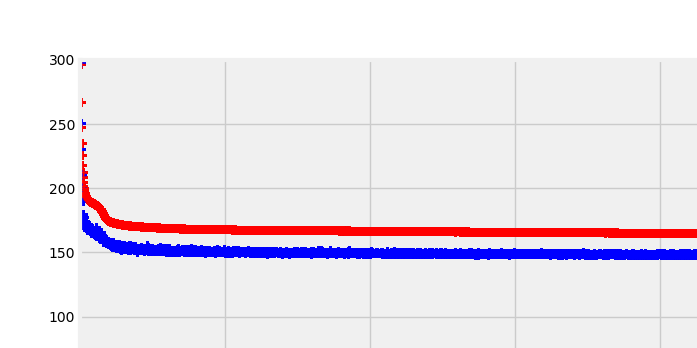

Files already downloaded and verified
Files already downloaded and verified
[epoch 000]  average testing loss: 622.5020
[epoch 000]  average training loss: 2676.4466
[epoch 001]  average testing loss: 371.0290
[epoch 001]  average training loss: 482.5920
[epoch 002]  average testing loss: 297.4266
[epoch 002]  average training loss: 351.0900
[epoch 003]  average testing loss: 251.2571
[epoch 003]  average training loss: 297.1377
[epoch 004]  average testing loss: 230.5556
[epoch 004]  average training loss: 267.3446
[epoch 005]  average testing loss: 212.7096
[epoch 005]  average training loss: 248.0989
[epoch 006]  average testing loss: 210.0859
[epoch 006]  average training loss: 235.2116
[epoch 007]  average testing loss: 201.1277
[epoch 007]  average training loss: 225.6789
[epoch 008]  average testing loss: 190.3398
[epoch 008]  average training loss: 218.5288
[epoch 009]  average testing loss: 190.3581
[epoch 009]  average training loss: 212.7724
[epoch 010]  average testing loss

In [ ]:
results_array=np.zeros((1,2))

results_array_temp=np.zeros((1,2))

results_array_test=np.zeros((1,2))

results_array_temp_test=np.zeros((1,2))


fig = plt.figure(figsize=[10.,5.])
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

plt.xlim(0, 3000)
plt.ylim(0, 300)


train_loader,test_loader = dataloader_first()
# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adagrad_params = {"lr": 0.00003}
optimizer = Adagrad(adagrad_params)


svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    train_elbo.append(-total_epoch_loss_train)
    
    
    if epoch%1 == 0:
    # --------------------------Do testing for each epoch here--------------------------------
    # initialize loss accumulator
        test_loss = 0.
    # compute the loss over the entire test set
        for x_test,y_test in test_loader:

            x_test = x_test.cuda()
            y_test = y_test.cuda()
            # compute ELBO estimate and accumulate loss
            labels_y_test = torch.tensor(np.zeros((y_test.shape[0],2)))
            y_test_2=torch.Tensor.cpu(y_test.reshape(1,y_test.size()[0])[0]).numpy().astype(int)  
            labels_y_test=np.eye(2)[y_test_2]
            labels_y_test = torch.from_numpy(labels_y_test)
        
            test_loss += svi.evaluate_loss(x_test.reshape(-1,10000),labels_y_test.cuda().float()) #Data entry point <---------------------------------Data Entry Point
            
            
            
            
        normalizer_test = len(test_loader.dataset)
        total_epoch_loss_test = test_loss / normalizer_test
        
        results_array_temp_test[0,:][0] = epoch
        results_array_temp_test[0,:][1] = total_epoch_loss_test
        results_array_test=np.vstack((results_array_test,results_array_temp_test))
        print("[epoch %03d]  average testing loss: %.4f" % (epoch, total_epoch_loss_test))

        
        ax.plot(results_array_test[:,0],results_array_test[:,1],'b+')

        
    
  # ------------------------Plotting Mechanism-----------------------------------------  
    results_array_temp[0,:][0] = epoch
    results_array_temp[0,:][1] = total_epoch_loss_train
    results_array=np.vstack((results_array,results_array_temp))
    
    ax.plot(results_array[:,0],results_array[:,1],'r+')
    
    fig.canvas.draw()
    
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))


In [13]:
train_loader,test_loader = dataloader_first()

Files already downloaded and verified
Files already downloaded and verified


In [53]:
for x_test,y_test in test_loader:
        

In [54]:
labels_y_test

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]], dtype=torch.float64)

In [51]:
y_test_2=torch.Tensor.cpu(y_test.reshape(1,y_test.size()[0])[0]).numpy().astype(int)

In [52]:
np.eye(2)[y_test_2]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [38]:
y

array([0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
def single_image_sampler(z0=0.0,z1=0.0, z2=0.0, z3=0.0, z4=0.0, z5=0.0, z6=0.0, z7=0.0, z8=0.0, z9=0.0):
    z = torch.rand(1,10)
    z[0,0]=z0
    z[0,1]=z1
    z[0,2]=z2
    z[0,3]=z3
    z[0,4]=z4
    z[0,5]=z5   
    z[0,6]=z6
    z[0,7]=z7    
    z[0,8]=z8
    z[0,9]=z9
    labels_y = torch.tensor(np.zeros((10)))
    labels_y[0] = 1
    single_sample_image = vae.decoder([z,labels_y.float()])
    image_array_single =single_sample_image.reshape(28,28).cpu().detach().numpy()
    temp_array=image_array_single
  #  plt.figure(figsize = (10,10))
  #  plt.imshow(image_array_single)
 #   plt.colorbar()
 #   plt.show() 
    return image_array_single

In [ ]:
rand_0 = np.random.uniform(-2,2)
rand_1 = np.random.uniform(-2,2)
rand_2 = np.random.uniform(-0.5,0.5)
rand_3 = np.random.uniform(-0.2,0.4)
rand_4 = np.random.uniform(-1,1)
rand_5 = np.random.uniform(-0.1,0.1)
rand_6 = np.random.uniform(-0.1,0.2)
rand_7 = np.random.uniform(-2.3,2.5)
rand_8 = np.random.uniform(-0.2,0.2)
rand_9 = np.random.uniform(-0.2,0.2)
image = single_image_sampler(rand_0,rand_1,rand_2,rand_3,rand_4,rand_5,rand_6,rand_7,rand_8,rand_9)
img_max = image.max() 
plt.imshow(image)
plt.show()

In [145]:
from torchvision.utils import save_image
with torch.no_grad():
    count = 0
    z_fr1 = z_fr2 = torch.randn(100, 2)
    labels_y1 = torch.tensor(np.zeros((100,2)))
    labels_y2 = torch.tensor(np.zeros((100,2)))
    for i in range (0,10):
        for j in range (0,10):
            z_fr1[count,0] = z_fr2[count,0] = np.random.uniform(-10,0.5)
            z_fr1[count,1] = z_fr2[count,1] = np.random.uniform(-10,0.5)
            labels_y1[count,0] = 1
            labels_y2[count,1] = 1
            count = count +1 
        
    sample1 = vae.decoder([z_fr1.cuda(),labels_y1.cuda().float()])
    
    save_image(sample1.view(100, 1, 100, 100), 'fr2_sample_z_space_' +str(epoch)+'.png',nrow=10)
    
    sample2 = vae.decoder([z_fr2.cuda(),labels_y2.cuda().float()])

    save_image(sample2.view(100, 1, 100, 100), 'fr1_sample_z_space_' +str(epoch)+'.png',nrow=10) 

In [ ]:
sample.reshape(100,100).cpu().detach().numpy()

In [ ]:
z = torch.randn(1, 2)
labels_y = torch.tensor(np.zeros((1,2)))
z[0,0]=0.5
z[0,1]=1.7
labels_y[0,1] = 0
labels_y[0,0] = 0
labels_y[0,1] = 1
sample = vae.decoder([z,labels_y.float()])

temp_array=sample.reshape(100,100).cpu().detach().numpy()
plt.figure(figsize = (10,10))
plt.imshow(temp_array)
plt.colorbar()
plt.show()



In [ ]:
z = torch.randn(1, 2)
labels_y = torch.tensor(np.zeros((1,2)))
z[0,0]=0.5
z[0,1]=1.7
labels_y[0,1] = 0
labels_y[0,0] = 0
labels_y[0,0] = 1
sample = vae.decoder([z,labels_y.float()])

temp_array=sample.reshape(100,100).cpu().detach().numpy()
plt.figure(figsize = (10,10))
plt.imshow(temp_array)
plt.colorbar()
plt.show()

In [148]:
from torchsummary import summary

TypeError: apply() missing 1 required positional argument: 'fn'